<a href="https://colab.research.google.com/github/rallyfranky/my-first-repo/blob/main/signate_comp_Lgb_bayesOpt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd

In [39]:
train = pd.read_csv('/content/drive/MyDrive/signate/train.csv')
test = pd.read_csv('/content/drive/MyDrive/signate/test .csv')

In [40]:
train.head()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0


(array([  12., 3334.,    6.,  768., 1588., 1457.,  126.,    0.,  357.,
         352.]),
 array([16650. , 16995.1, 17340.2, 17685.3, 18030.4, 18375.5, 18720.6,
        19065.7, 19410.8, 19755.9, 20101. ]),
 <a list of 10 Patch objects>)

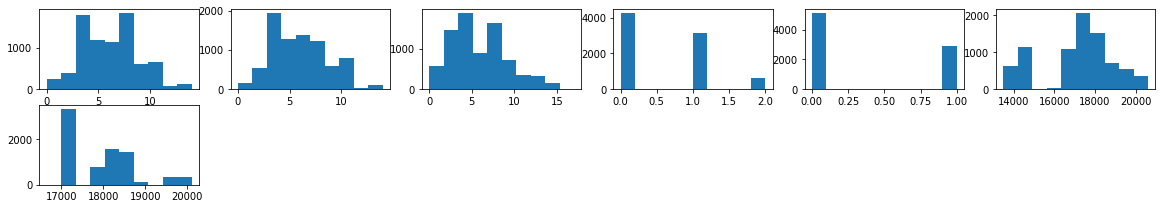

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
fig = plt.subplot(3,6,1)
plt.hist(train['blueKills'],bins=10)
fig = plt.subplot(3,6,2)
plt.hist(train['blueDeaths'],bins=10)
fig = plt.subplot(3,6,3)
plt.hist(train['blueAssists'],bins=10)
fig = plt.subplot(3,6,4)
plt.hist(train['blueEliteMonsters'],bins=10)
fig = plt.subplot(3,6,5)
plt.hist(train['blueDragons'],bins=10)
fig = plt.subplot(3,6,6)
plt.hist(train['blueTotalGold'],bins=10)
fig = plt.subplot(3,6,7)
plt.hist(train['blueTotalExperience'],bins=10)

In [42]:
label_FB_mean = train.groupby('blueFirstBlood').blueWins.mean()
label_DG_mean = train.groupby('blueDragons').blueWins.mean()

print(label_FB_mean)
print(label_DG_mean)

blueFirstBlood
0    0.375513
1    0.602096
Name: blueWins, dtype: float64
blueDragons
0    0.397663
1    0.660384
Name: blueWins, dtype: float64


In [43]:
train['target_flg'] = 1
test['target_flg'] = 0
train_y = train['blueWins']
train = train.drop('blueWins',axis=1)

In [44]:
df = pd.concat([train, test])

In [45]:
df = df.assign(t_enc_FB=df['blueFirstBlood'].map(label_FB_mean).copy())
df = df.assign(t_enc_DG=df['blueFirstBlood'].map(label_DG_mean).copy())

In [46]:
train_x = df[df['target_flg']==1]

In [48]:
train_x = train_x.drop('target_flg',axis=1)

In [51]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [52]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.5 MB/s eta 0:00:00


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

train_x['wins'] = train_y

In [57]:
train_set, test_set = train_test_split(train_x, test_size=0.2, random_state=0)
X_train = train_set.drop(['wins'], axis=1)
y_train = train_set['wins']
X_test = test_set.drop(['wins'], axis=1)
y_test = test_set['wins']

In [58]:
def objective(trial):
#    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(X_train, label=y_train)
 
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [59]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-22 13:24:01,243] A new study created in memory with name: no-name-687b9d1b-806d-4b46-a3a9-4e70f5c66bbf
<ipython-input-58-b9065a5aeb31>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-58-b9065a5aeb31>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-58-b9065a5aeb31>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

Number of finished trials: 100
Best trial: {'lambda_l1': 2.2203448623105378e-07, 'lambda_l2': 2.8111609843928563e-08, 'num_leaves': 70, 'feature_fraction': 0.917115263013398, 'bagging_fraction': 0.7680157077283467, 'bagging_freq': 4, 'min_child_samples': 100}


In [60]:
print('Best score is{}'.format(study.best_value))

Best score is0.81625


In [62]:
train_y = df[df['target_flg']==0]

In [64]:
train_y = train_y.drop('target_flg',axis=1)

In [67]:
param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': 2.2203448623105378e-07,
        'lambda_l2': 2.8111609843928563e-08,
        'num_leaves': 70,
        'feature_fraction': 0.917115263013398,
        'bagging_fraction': 0.7680157077283467,
        'bagging_freq': 4,
        'min_child_samples': 100,
    }
dtrain = lgb.Dataset(X_train, label=y_train)
model = lgb.train(param, dtrain)
train_y['pred'] = model.predict(train_y)

In [68]:
train_y['pred'] = np.rint(train_y['pred'])

In [69]:
train_y

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,t_enc_FB,t_enc_DG,pred
0,9,0,7,6,6,0,0,16961,18201,0.375513,0.397663,1.0
1,15,0,6,6,6,2,1,18513,18021,0.375513,0.397663,1.0
2,18,1,6,4,3,0,0,13475,17256,0.602096,0.660384,1.0
3,23,0,5,4,7,0,0,17409,17256,0.375513,0.397663,0.0
4,31,0,10,8,9,0,0,18117,18472,0.375513,0.397663,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256,0.375513,0.397663,0.0
1996,9980,0,4,4,4,0,0,17409,17256,0.375513,0.397663,0.0
1997,9983,1,6,3,3,1,1,18513,18201,0.602096,0.660384,1.0
1998,9996,1,10,9,9,1,1,18513,18201,0.602096,0.660384,1.0


In [72]:
submit = train_y[['gameId','pred']]

In [73]:
submit.to_csv('submit.csv')